In [2]:
import numpy as np
b=np.load('ny.eater-content-new.npy')
content=b.tolist()

In [3]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [5]:
new_content = []
for article in content:
    text = ""
    for sent in article:
        text = text + sent
    new_content.append(text)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(article)).lower() for article in new_content)

In [7]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.47 mins


In [8]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(395, 1)

In [9]:
from gensim.models.phrases import Phrases, Phraser

In [10]:
sent = [row.split() for row in df_clean['clean']]

In [11]:
bigram = Phrases(sent, min_count=30, progress_per=10000)

INFO - 10:39:25: collecting all words and their counts
INFO - 10:39:25: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:39:25: collected 240879 word types from a corpus of 290176 words (unigram + bigrams) and 395 sentences
INFO - 10:39:25: using 240879 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [12]:
#bigram = Phraser(phrases)

In [13]:
sentences = bigram[sent]

In [14]:
print(bigram[sent])

In [15]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

22922

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['s', 'restaurant', "'s", 'like', 'be', 'dish', 'good', 'menu', 'food', 'chef']

In [17]:
import multiprocessing

from gensim.models import Word2Vec

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [19]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [20]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:39:27: collecting all words and their counts
INFO - 10:39:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:39:28: collected 22922 word types from a corpus of 281782 raw words and 395 sentences
INFO - 10:39:28: Loading a fresh vocabulary
INFO - 10:39:28: effective_min_count=20 retains 2629 unique words (11% of original 22922, drops 20293)
INFO - 10:39:28: effective_min_count=20 leaves 210633 word corpus (74% of original 281782, drops 71149)
INFO - 10:39:28: deleting the raw counts dictionary of 22922 items
INFO - 10:39:28: sample=6e-05 downsamples 1616 most-common words
INFO - 10:39:28: downsampling leaves estimated 101776 word corpus (48.3% of prior 210633)
INFO - 10:39:28: estimated required memory for 2629 words and 300 dimensions: 7624100 bytes
INFO - 10:39:28: resetting layer weights


Time to build vocab: 0.03 mins


In [21]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:39:28: training model with 11 workers on 2629 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 10:39:29: EPOCH 1 - PROGRESS: at 58.99% examples, 61196 words/s, in_qsize 0, out_qsize 0
INFO - 10:39:30: worker thread finished; awaiting finish of 10 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 9 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 8 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 7 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 6 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 5 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 4 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 3 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 2 more threads
INFO - 10:39:30: worker thread finished; awaiting finish of 1 more threads
INFO - 10:39:30: w

INFO - 10:39:40: worker thread finished; awaiting finish of 0 more threads
INFO - 10:39:40: EPOCH - 8 : training on 281782 raw words (102150 effective words) took 1.4s, 72691 effective words/s
INFO - 10:39:41: EPOCH 9 - PROGRESS: at 71.65% examples, 73652 words/s, in_qsize 0, out_qsize 0
INFO - 10:39:41: worker thread finished; awaiting finish of 10 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 9 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 8 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 7 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 6 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 5 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 4 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 3 more threads
INFO - 10:39:41: worker thread finished; awaiting finish of 2 more threads
INFO - 10:39:41: worker thread fini

INFO - 10:39:52: worker thread finished; awaiting finish of 1 more threads
INFO - 10:39:52: worker thread finished; awaiting finish of 0 more threads
INFO - 10:39:52: EPOCH - 16 : training on 281782 raw words (101832 effective words) took 1.3s, 77148 effective words/s
INFO - 10:39:53: EPOCH 17 - PROGRESS: at 65.82% examples, 66198 words/s, in_qsize 0, out_qsize 1
INFO - 10:39:53: worker thread finished; awaiting finish of 10 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 9 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 8 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 7 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 6 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 5 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 4 more threads
INFO - 10:39:53: worker thread finished; awaiting finish of 3 more threads
INFO - 10:39:53: worker thread fi

INFO - 10:40:03: worker thread finished; awaiting finish of 2 more threads
INFO - 10:40:03: worker thread finished; awaiting finish of 1 more threads
INFO - 10:40:03: worker thread finished; awaiting finish of 0 more threads
INFO - 10:40:03: EPOCH - 24 : training on 281782 raw words (101792 effective words) took 1.6s, 63415 effective words/s
INFO - 10:40:04: EPOCH 25 - PROGRESS: at 52.41% examples, 55757 words/s, in_qsize 1, out_qsize 0
INFO - 10:40:05: worker thread finished; awaiting finish of 10 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 9 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 8 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 7 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 6 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 5 more threads
INFO - 10:40:05: worker thread finished; awaiting finish of 4 more threads
INFO - 10:40:05: worker thread fi

Time to train the model: 0.75 mins


In [22]:
w2v_model.init_sims(replace=True)

INFO - 10:40:13: precomputing L2-norms of word weight vectors


In [25]:
w2v_model.wv.most_similar(positive=["beef","chicken","fish"])

[('pork', 0.9840567111968994),
 ('lamb', 0.9713866114616394),
 ('sauteed', 0.9637244939804077),
 ('rib', 0.9601218700408936),
 ('fry', 0.9590514898300171),
 ('kebab', 0.956694483757019),
 ('stew', 0.9524548649787903),
 ('chicken_wing', 0.9482629895210266),
 ('meatball', 0.9469231367111206),
 ('grill', 0.9456901550292969)]

In [25]:
for each in w2v_model.predict_output_word(['chicken'],100):
    if nlp(each[0])[0].pos_ == 'NOUN': #NOUN,VERB
        print (each)

('sauteed', 0.0009075872)
('queso', 0.000869389)
('biryani', 0.0008498551)
('paneer', 0.00084196054)
('pao', 0.00080325606)
('curry', 0.00080078305)
('masala', 0.0007994436)
('mofongo', 0.00079513475)
('entr_e', 0.00077619834)
('fritter', 0.00077479327)
('oxtail', 0.00077331095)
('plantain', 0.0007628969)
('boneless', 0.00075039006)
('assortment', 0.0007444519)
('vegan', 0.00074372935)
('hunan', 0.0007404213)
('roti', 0.00073781505)
('chow', 0.0007369584)
('goat', 0.000727191)
('papaya', 0.00072706136)
('pork', 0.0007193554)
('chicken', 0.0007175683)
('eel', 0.000717245)
('lamb', 0.000715312)
('pisco', 0.00071329874)
('braise', 0.00070664997)
('app', 0.0006990632)
('momo', 0.0006958833)
('noodle', 0.000692139)
('kebab', 0.0006893638)
('cost_dinner', 0.0006845835)
('appetizer', 0.000681779)
('shanghai', 0.0006806231)
('empanada', 0.0006792542)
('shrimp', 0.0006786865)
('main_course', 0.00067574653)
('nigiri', 0.0006733656)
('side', 0.00067331886)
('okra', 0.0006720624)
('larb', 0.000669

C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\shile\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


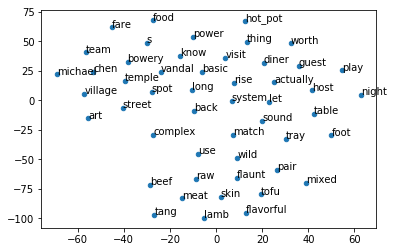

In [59]:
import numpy as np
labels = []
count = 0
max_count = 50
X = np.zeros(shape=(max_count,len(w2v_model['beef'])))

for term in w2v_model.wv.vocab:
    X[count] = w2v_model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()

In [60]:
w2v_model.wv.most_similar(positive=["beef","chicken","pork"], negative=["spicy"], topn=3)

[('lamb', 0.9443982839584351),
 ('fry', 0.9257964491844177),
 ('kebab', 0.9211352467536926)]

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [72]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

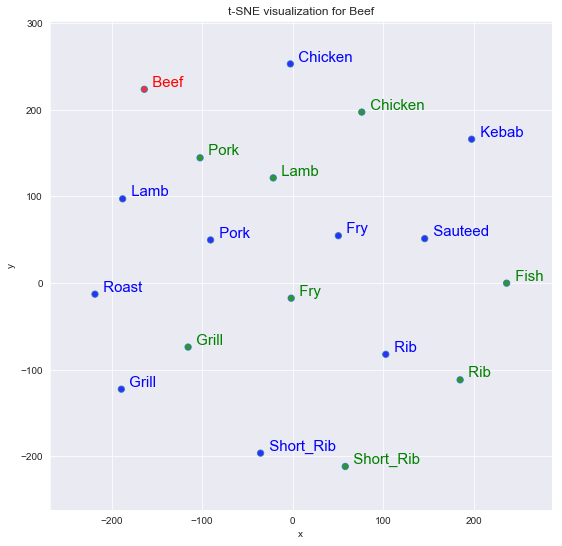

In [76]:
tsnescatterplot(w2v_model, 'beef', ['lamb','pork', 'chicken', 'grill', 'fish','rib', 'short_rib', 'fry'])

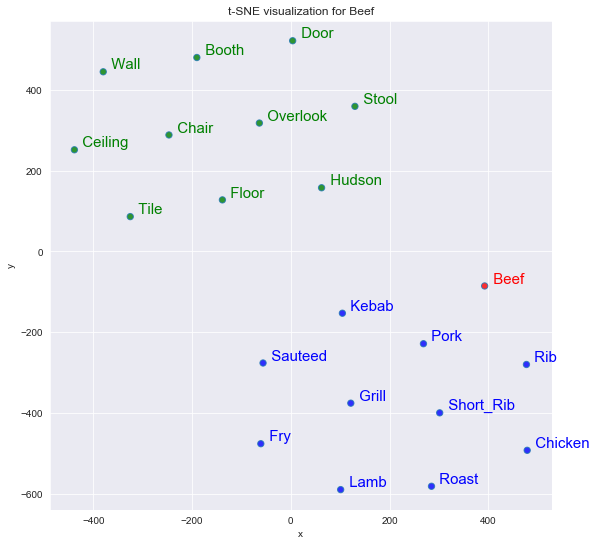

In [77]:
tsnescatterplot(w2v_model, 'beef', [i[0] for i in w2v_model.wv.most_similar(negative=["beef"])])

In [75]:
1. catagory
2. pos & neg
3. top ten similarity

SyntaxError: invalid syntax (<ipython-input-75-ac030bf80383>, line 1)